In [1]:
%pylab inline
import numpy as np
from tqdm import trange
import torch

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def fetch(url):
    import requests, gzip, os, hashlib
    fp = os.path.join('data/', url)
    if os.path.isfile(fp):
        with open(fp, 'rb') as f:
            dat = f.read()
    else:
        print("You need to download the dataset (from https://deepai.org/dataset/mnist)")
    return np.frombuffer(gzip.decompress(dat),dtype=np.uint8)


In [3]:
# https://deepai.org/dataset/mnist
X_train = fetch('train-images-idx3-ubyte.gz')[0x10:].reshape((-1, 28, 28)) # the -1 in the reshape inferres from the other dims
Y_train = fetch('train-labels-idx1-ubyte.gz')[8:]
X_test = fetch('t10k-images-idx3-ubyte.gz')[0x10:].reshape((-1,28,28))
Y_test = fetch('t10k-labels-idx1-ubyte.gz')[8:]

7449


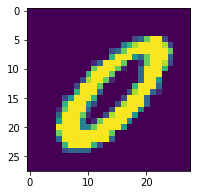

In [4]:
figsize(3,3)
samp = np.random.randint(0,X_test.shape[0])
imshow(X_test[samp])
print(samp)
#Y_train[0]

In [ ]:
torch.argmax(model(torch.tensor(X_test[samp].reshape(-1,28*28)).float()) , dim = 1).item()

In [ ]:
X_train[:32].reshape(32, 28*28).shape

In [ ]:
# let's build a simple net, BobNet. It consists of two linear layers and a relu in between. No biases for now. 
# 
# L1: The first layer consist of 28*28 = 784 inputs. This is the size of our image. It outputs a compressed version of that, lets say 128 (take a power of two?) this can vary though
# Activation RELU: then we apply a non-linear function. This cuts offs all the negative values I think.
# L2: then we apply another linear layer (dense is the same??) with 128 outputs and 10 outputs, since we have 10 digits. 
# 
# So at the end we have: 1 x 784 input -> 784 x 128 -> 128 x 10 -> 1 x 10. This 
# 
#  
# we get a vector of size 10, with probabilities in it. After L2 we would need to get the probs, with a softmax for instance. A soft max is just exp/sum of exps to normalize and have a probability distribution. However, we can just take the maximum value of that array as our prediction (the index will be our predicition. 

In [5]:
# ============= IN PYTORCH =====================
import torch
import torch.nn as nn   

# define the model and the forward pass
class BobNet(nn.Module):
    def __init__(self):
        super(BobNet, self).__init__()
        self.l1 = nn.Linear(784, 128, bias=False)
        self.act = nn.ReLU()
        self.l2 = nn.Linear(128, 10, bias=False)
    
    def forward(self, x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)

        return x

In [6]:

# init model
model = BobNet()
losses, accuracies = [], []

In [7]:
batch_size = 32
lr = 0.001
loss_function = nn.CrossEntropyLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)

for i in (t := trange(1000)):
    # == CHOOSE SAMPLES
    # choose samples and true ground
    
    sample_choice = np.random.randint(0, X_train.shape[0], size=(batch_size))
    X = torch.tensor(X_train[sample_choice].reshape(-1, 28*28)).float()
    Y = torch.tensor(Y_train[sample_choice]).long()
    
    # set the optimzer grades to zero grads
    optim.zero_grad()

    # == FORWARD PASS ==
    # forward  pass of BobNet
    out = model(X)
    out.retain_grad()

    # to get the accuracy compare with the test
    cat = torch.argmax(out, dim=1) 
    accuracy = (cat == Y).float().mean()
    
    # compute the loss function
    loss = loss_function(out,Y).mean()
    #print(loss)

    # == BACKWARD PASS ==
    loss.backward()
    
    

    # == UPDATE ==
    optim.step()

    # retain stuff .item() for scalars only
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    
    t.set_description(f" loss: {loss:.4f}, accuracy: {accuracy:.4f}")


 loss: 0.1516, accuracy: 0.9688: 100%|██████████| 1000/1000 [00:02<00:00, 377.47it/s]


(<matplotlib.image.AxesImage at 0x11b0e0d30>,
 tensor([2, 5, 5, 0, 6, 1, 2, 5, 3, 1, 8, 1, 4, 5, 8, 8, 4, 0, 2, 4, 9, 1, 8, 3,
         7, 2, 6, 1, 4, 7, 3, 1]))

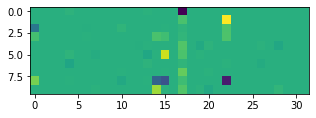

In [8]:
figsize(5,5)
imshow(out.grad.T), Y

In [ ]:
fig, ax = plt.subplots()
ax.set_yscale('log')
figsize(20,5)
plot(losses)
plot(accuracies)

In [ ]:
figsize(15,15)
imshow(model.l2.weight.grad)
figure()
imshow(model.l1.weight.grad)

In [7]:
def pytorch_eval():
    x_test = torch.argmax(model(torch.tensor(X_test[:].reshape(-1,28*28)).float()) , dim = 1)
    y_test = torch.tensor(Y_test[:])
    return (x_test == y_test).float().mean().item()

In [ ]:
pytorch_eval()

In [ ]:
# ============= IN NUMPY ONLY =====================
l1 = np.zeros(shape=(28*28,128), dtype=np.float32)
l2 = np.zeros(shape=(128,10), dtype=np.float32)

l1.shape, l2.shape, id(l1), id(l2)

In [5]:
# elegant. from stackoverflow
def ReLU(x):
    return x * (x > 0)

In [6]:
# forward pass numpy
def forward(x):
    x = x.dot(l1)
    x = ReLU(x)
    x = x.dot(l2)
    return x

In [ ]:
# lets get for now the weights from pytorch training
l1[:] = model.l1.weight.detach().numpy().T # by broadcasting [:] we are not creating another array
l2[:] = model.l2.weight.detach().numpy().T
losses, accuracies = [], []

# L1[:] = np.random.randn(28*28,il)
# L2[:] = np.random.randn(il, 10)

In [ ]:
l1.shape, l2.shape

In [ ]:
r = np.random.randint(0,10000)
figsize(3,3)
plt.imshow(X_test[r])
print('sample: ', r)
print('pred:',np.argmax(forward(X_test[r].reshape(-1,28*28))))
print('true: ', Y_test[r])

In [ ]:
def numpy_eval():
    x = np.argmax(forward(X_test.reshape(-1,28*28)), axis=1)
    y = Y_test
    return (x == y).mean()

In [ ]:
# loss function for the predictions
Y_preds = forward(X_test[:].reshape(-1,28*28))
ret = - Y_preds[np.arange(Y_test.shape[0]), Y_test[:]] + np.log(np.sum(np.exp(Y_preds), axis=1))
print(ret.mean())

In [ ]:
plot(ret)

In [ ]:
# the most beautiful way of plotting a grid. But need to study more the concatenate stuff...
G = 4
figsize(10,10)
plt.axis("off")
grid = sorted(list(zip(ret, range(ret.shape[0]))), reverse=False)[0:G*G]
imshow(np.concatenate(X_test[[x[1] for x in grid]].reshape(G, G*28, 28),axis=1))
print(Y_test[[x[1] for x in grid]].reshape(G,G).T)

# cross entropy loss backprop in Pytorch 

In [ ]:
# how to diferentiate matrices
# http://cs231n.stanford.edu/vecDerivs.pdf
# https://cs231n.github.io/optimization-2/

# basically: y = M x -> dy/dx = M  and dy_j/dW_ik = x_i delta_jk 

In [ ]:
Y_preds[3906]

In [ ]:
out = np.zeros((1,10), np.float32)
out[Y_test[1]] = 1
out

In [ ]:
#idx = np.array([1234,3906])
gout = np.zeros((32,10), np.float32)
# out[np.arange(2),Y_test[idx]] = 1
gout[np.arange(32),Y] = 1
gout = torch.tensor(gout)

gin = torch.tensor(out, requires_grad=True).float()
gin.retain_grad()
gin

glsm = torch.nn.functional.log_softmax(gin, dim=1)
glsm.retain_grad()
glsm

loss = (- gout * glsm).mean()

loss.backward()
imshow(gin.grad.T)
figure()
imshow(out.grad.T)

In [ ]:
# understand gradients
torch.set_printoptions(sci_mode=False)
bs=2
idx = np.array([1234,3906])
model.zero_grad()
X = torch.tensor(X_test[idx].reshape(-1, 28*28)).float()
Y = torch.tensor(Y_test[idx]).long()

# idx = np.random.randint(0,Y_test.shape[0])
out = np.zeros((bs,10), np.float32)
out[np.arange(bs),Y[idx].detach().numpy()] = 1
out = torch.tensor(out)

Y_preds = model(X)
# simple example in pytorhc. the last step, from y_pred = model(x_pred)
# this is what we would get from the model, our prediction
gin = torch.tensor(Y_preds[idx], requires_grad=True).float()
gin.retain_grad()
# the loss function is the cross entropy loss. it is basically a logsoftmax of the prediction (it's a 10 dim vector)
# with the one hot encoding of the result (all zeros and a one)
glsm = torch.nn.functional.log_softmax(gin, dim=1)
glsm.retain_grad()
loss = (- out * glsm).mean() # actually the means does nothing i guess...unless we use batch?
loss.retain_grad()
# # backward 
loss.backward()

print(f"{loss}")

In [ ]:
loss, loss.grad ,glsm, glsm.grad, gin, gin.grad

In [ ]:
dloss_dloss = 1
print(f'{dloss_dloss=}')
dloss_dglsm = - out/out.shape[0] * dloss_dloss 
print(f'{dloss_dglsm=}')
dloss_gin = dloss_dglsm - torch.exp(glsm)*dloss_dglsm.sum() # dloss_dglsm_i * I_ij - dloss_dglsm_i * ( exp(glsm)_ij )
print(f'{dloss_gin=}')

# cross entropy loss backprop in Numpy 

In [ ]:
np.set_printoptions(precision=4, suppress=True)

In [ ]:
#  forward pass (from pred)

l1 = np.zeros(shape=(28*28,128), dtype=np.float32)
l2 = np.zeros(shape=(128,10), dtype=np.float32)


xin = Y_preds[idx]
xlsm = xin - np.log(np.exp(xin).sum())

out = np.zeros(10)
out[Y_test[idx]] = 1

xloss = (-out * xlsm).mean()

# backprop

xdloss_dloss = 1
print(f'{xdloss_dloss=}')
xdloss_dglsm = - out/out.shape[0] * xdloss_dloss 
print(f'{xdloss_dglsm=}')
xdloss_gin = xdloss_dglsm - np.exp(xlsm)*xdloss_dglsm.sum() # dloss_dglsm_i * I_ij - dloss_dglsm_i * ( exp(glsm)_ij )
print(f'{xdloss_gin=}')


# forward pass and backward pass in numpy

In [ ]:
model.l1.weight.shape

In [ ]:
imshow(model.l2.weight.grad.detach().numpy())
figure()
imshow(l2)

In [ ]:
model(torch.tensor(X_test[idx]).reshape(-1,28*28).float())

In [ ]:
Y_preds[idx]

In [ ]:
xx_in = X_test[idx].reshape(-1,28*28)
xx_l1 = xx_in.dot(l1)
xx_relu = ReLU(xx_l1)
xx_l2 = xx_relu.dot(l2)

In [ ]:
xx_l2

In [ ]:
xdloss_gin.shape

In [ ]:
imshow(xx_relu.T.dot(xdloss_gin).T)

In [ ]:
imshow(model.l2.weight.grad.detach().numpy())

In [215]:
# understand gradients TORCH
torch.set_printoptions(precision=4,sci_mode=False)
np.set_printoptions(precision=4,suppress=True)
bs=32

In [511]:
#idx = np.random.randint(0, X_train.shape[0],32)
#idx = np.array([3906])
model = BobNet()

seed = np.random.randint(0,2**32)
lr = 0.001
bs = 32
n=4000
print(seed)

385135555


In [512]:
# understand gradients TORCH BO
#model.zero_grad()

loss_function = nn.CrossEntropyLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)
losses, accuracies = [], []
np.random.seed(seed)

#print("=============")
#print(model.l1.weight.T, model.l2.weight.T)
#print("=============")

for i in (t := trange(n)):
    # == CHOOSE SAMPLES
    # choose samples and true ground
    
    optim.zero_grad()
    idx = np.random.randint(0, X_train.shape[0], size=(bs))
    X = torch.tensor(X_train[idx].reshape(-1, 28*28)).float()
    Y = torch.tensor(Y_train[idx]).long()
    
    gin = model(X)
    #gin.retain_grad()
      
    # compute the loss function
    loss = loss_function(gin,Y)
    loss = loss.mean()
    #print(loss)
    #loss.retain_grad()
    
    
    # to get the accuracy compare with the test
    cat = torch.argmax(gin, dim=1) 
    accuracy = (cat == Y).float().mean()
    
    # == BACKWARD PASS ==
    loss.backward()
    
    
  

    # == UPDATE ==
    optim.step()

    # retain stuff .item() for scalars only
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)   
    
    
    t.set_description(f" loss: {loss:.4f}, accuracy: {accuracy:.4f}")

#figsize(16,16)
#imshow(model.l1.weight.grad)
#figure()
#imshow(model.l2.weight.grad)

 loss: 0.0826, accuracy: 0.9688: 100%|█████| 4000/4000 [00:10<00:00, 391.13it/s]


In [631]:
#  understanding gradients numpy
#l1[:] = model.l1.weight.detach().numpy().T # by broadcasting [:] we are not creating another array
#l2[:] = model.l2.weight.detach().numpy().T
np.random.seed()

def linear_layer(in_f, out_f):
    k = np.sqrt(1./(in_f*out_f)) # linear geohot works better xD
    #k = np.sqrt(2) * np.sqrt(3./in_f) # kaiming
    return np.random.uniform(-1, 1, size=(in_f, out_f)) * k
    
#l1 = np.zeros(shape=(28*28,128), dtype=np.float32)
#l2 = np.zeros(shape=(128,10), dtype=np.float32)
#l1[:] = model.l1.weight.detach().numpy().T # by broadcasting [:] we are not creating another array
#l2[:] = model.l2.weight.detach().numpy().T
l1 = linear_layer(28*28, 128)
l2 = linear_layer(128,10)

losses, accuracies = [], []
np.random.seed(seed)

def logexpsum(xin):
    #xstar = np.max(xin, axis=1).reshape(xin.shape[0],1)
    #xstar = np.max(a,axis=1).reshape(a.shape[0],-1)
    #print(np.exp(a - xstar))
    #ret = np.log(np.exp(a-xstar)/np.sum(np.exp(a - xstar), axis=1, keepdims=True)) 
    xstar = np.max(xin,axis=1).reshape(xin.shape[0],-1)
    ret = (xin - xstar) - np.log(np.exp(xin - xstar ).sum(axis=1,keepdims=True))

    return ret

def softmax(xin):
    xstar = np.max(xin,axis=1).reshape(xin.shape[0],-1)
    ret = np.exp(xin - xstar)/np.exp(xin - xstar).sum(axis=1,keepdims=True)
    return ret

#print("=============")
#print(l1,l2)
#print("=============")
for i in (t := trange(1000)):
    idx = np.random.randint(0, X_train.shape[0], size=(bs))
    # true ground
    out = np.zeros((Y_train[idx].shape[0],10), np.float32)
    out[np.arange(Y_train[idx].shape[0]),Y_train[idx]] = 1

    # forward
    xx_in = X_train[idx].reshape(-1,28*28)
    xx_l1 = xx_in.dot(l1)
    xx_relu = ReLU(xx_l1)
    xx_l2 = xx_relu.dot(l2)
    xin = xx_l2
    

    xlsm = logexpsum(xin)
    xloss = (-out * xlsm).sum(axis=1).mean()
    #print(xlsm, xloss)
    
    cat = np.argmax(xin, axis=1) 
    xaccuracy = (cat == Y_train[idx]).mean()
    #print(xaccuracy)
    
    # backprop

    xdloss_dloss = 1
    #print(f'{xdloss_dloss=}')
    xdloss_dglsm = - out / out.shape[0] * xdloss_dloss 
    #print(f'{xdloss_dglsm=}')
    xdloss_gin = xdloss_dglsm - softmax(xin)*xdloss_dglsm.sum(axis=1).reshape(out.shape[0],1) # dloss_dglsm_i * I_ij - dloss_dglsm_i * ( exp(glsm)_ij )
    #print(f'{xdloss_gin=}')
    xdloss_w2 = xx_relu.T.dot(xdloss_gin)
    #print(f'{xdloss_w2=}')
    xdloss_xw2 = xdloss_gin.dot(l2.T)
    xdloss_relu = xdloss_xw2 * 1.0 * (xx_l1 > 0) 
    xdloss_w1 = xx_in.T.dot(xdloss_relu)

    # update
    #ch = np.isnan(xdloss_w1).any()
    #assert ch != True
    l1 = l1 - lr * xdloss_w1
    l2 = l2 - lr * xdloss_w2
    
    
    # retain stuff .item() for scalars only
    losses.append(xloss)
    accuracies.append(xaccuracy)   
    
    
    t.set_description(f" loss: {xloss:.4f}, accuracy: {xaccuracy:.4f}")

#print("================")
#gin.grad, xdloss_gin, xloss, loss, xdloss_w2.T, model.l2.weight.grad

 loss: 0.1678, accuracy: 0.9062: 100%|█████| 1000/1000 [00:02<00:00, 385.55it/s]


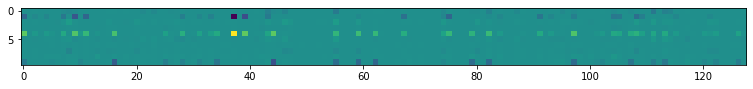

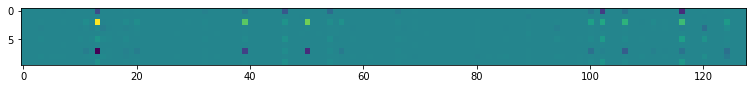

In [532]:
imshow(xdloss_w2.T)
figure()
imshow(model.l2.weight.grad)

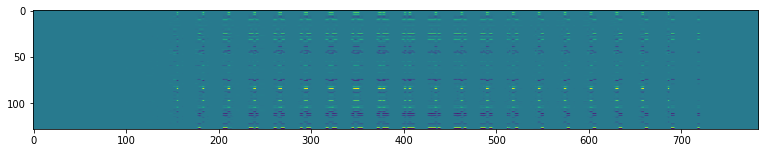

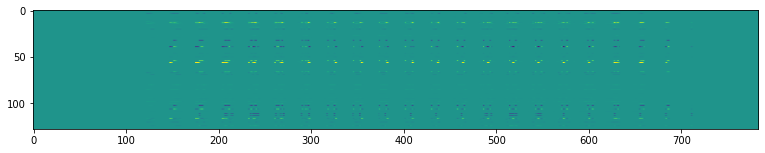

In [533]:
imshow(xdloss_w1.T)
figure()
imshow(model.l1.weight.grad)

In [493]:
def numpy_eval():
    x = np.argmax(forward(X_test.reshape(-1,28*28)), axis=1)
    y = Y_test
    return (x == y).mean()

def pytorch_eval():
    x_test = torch.argmax(model(torch.tensor(X_test[:].reshape(-1,28*28)).float()) , dim = 1)
    y_test = torch.tensor(Y_test[:])
    return (x_test == y_test).float().mean().item()

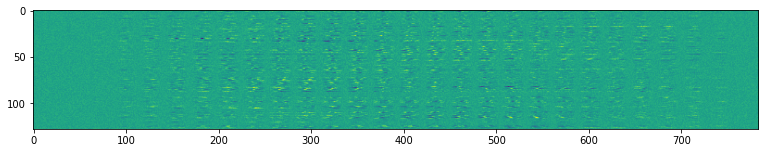

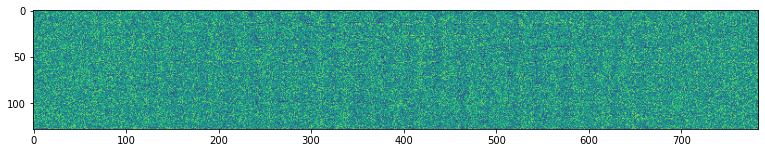

In [516]:
figsize(13,13)
imshow(l1.T)
figure()
imshow(model.l1.weight.detach().numpy())

In [534]:
numpy_eval(), pytorch_eval()

(0.9707, 0.9484000205993652)

In [648]:
idx = np.random.randint(0, X_train.shape[0], size=(1))
    # true ground
out = np.zeros((Y_train[idx].shape[0],10), np.float32)
out[np.arange(Y_train[idx].shape[0]),Y_train[idx]] = 1

    # forward
xx_in = X_train[idx].reshape(-1,28*28)
xx_l1 = xx_in.dot(l1)
xx_relu = ReLU(xx_l1)
xx_l2 = xx_relu.dot(l2)
xin = xx_l2
    

xlsm = logexpsum(xin)
xloss = (-out * xlsm).sum(axis=1).mean()
#print(xlsm, xloss)
    
#cat = np.argmax(xin, axis=1) 
#xaccuracy = (cat == Y_train[idx]).mean()
#print(xaccuracy)
    
# backprop

xdloss_dloss = 1
#print(f'{xdloss_dloss=}')
xdloss_dglsm = - out / out.shape[0] * xdloss_dloss 
#print(f'{xdloss_dglsm=}')
xdloss_gin = xdloss_dglsm - softmax(xin)*xdloss_dglsm.sum(axis=1).reshape(out.shape[0],1) # dloss_dglsm_i * I_ij - dloss_dglsm_i * ( exp(glsm)_ij )
#print(f'{xdloss_gin=}')
xdloss_w2 = xx_relu.T.dot(xdloss_gin)
#print(f'{xdloss_w2=}')
xdloss_xw2 = xdloss_gin.dot(l2.T)
xdloss_relu = xdloss_xw2 * 1.0 * (xx_l1 > 0) 
xdloss_w1 = xx_in.T.dot(xdloss_relu)  





array([-3.4996078721000705, -8.319981286496716 , -3.3337604517734984,
       -4.686105052515676 ,  8.258962656968574 , -1.0932239430442388,
       -1.6218767855923786,  2.8772617708839645,  1.2815652777493283,
        4.7012310949113845])

In [661]:
# numercial grad (complex step differentiation) better accuracy
# https://blogs.mathworks.com/cleve/2013/10/14/complex-step-differentiation/
h = 0.00001
for i in np.arange(xin.shape[1]):
    arr = xin[0].copy().astype(np.complex128)
    arr[i] += 1j*h   
    arr = np.array([arr])
    der = np.imag((-out * logexpsum(arr)).sum(axis=1).mean()/h)
    print(der)

0.00042982001269980716
8.696431390236382e-07
9.447627584609684e-05
4.850173370135338e-05
5.285695987356687e-08
2.5194606925962893e-05
2.1270099059403192e-07
2.78544630953474e-06
-0.0016885067333400937
0.0010865934567677743


In [662]:
# numercial grad (classic one)
h = 0.00001
for i in np.arange(xin.shape[1]):
    arr = xin[0].copy()
    arr[i] += h   
    arr1 = np.array([arr])
    arr[i] -= 2*h
    arr2 = np.array([arr])
    der = ( (-out * logexpsum(arr1)).sum(axis=1).mean() - (-out * logexpsum(arr2)).sum(axis=1).mean() ) / (2*h)
    print(der)

0.0004298200054664476
8.69643408934334e-07
9.44762720204821e-05
4.85017363077711e-05
5.2857132733230554e-08
2.5194599119655877e-05
2.1270314069093963e-07
2.785445788952567e-06
-0.0016885067283820344
0.0010865934548941365


In [652]:
xdloss_gin

array([[ 4.2982001270696176e-04,  8.6964313903813237e-07,
         9.4476275847671007e-05,  4.8501733702161630e-05,
         5.2856959874447822e-08,  2.5194606926382778e-05,
         2.1270099059757699e-07,  2.7854463095811648e-06,
        -1.6885067333679560e-03,  1.0865934567858254e-03]])

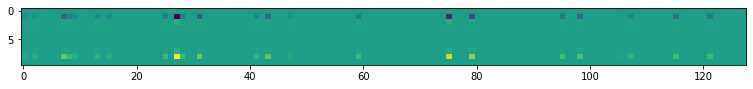

In [538]:
imshow(xdloss_w2.T)

In [528]:
xloss

0.005846097349431457